# NAME: SARAN ADHIKARI

# UNIVERSITY ID: 2329794

# WORKSHEET05

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
from sklearn.metrics import classification_report

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
img_height, img_width = 128, 128
batch_size = 32
epochs = 100
validation_split = 0.2

In [5]:
test_dir = '/content/drive/MyDrive/AI&ML/WEEK5/FruitinAmazon/FruitinAmazon/test'
train_dir = '/content/drive/MyDrive/AI&ML/WEEK5/FruitinAmazon/FruitinAmazon/train'

# TASK01: DATA UNDERSTANDING AND VISUALIZATION

Task 1: Visualizing samples


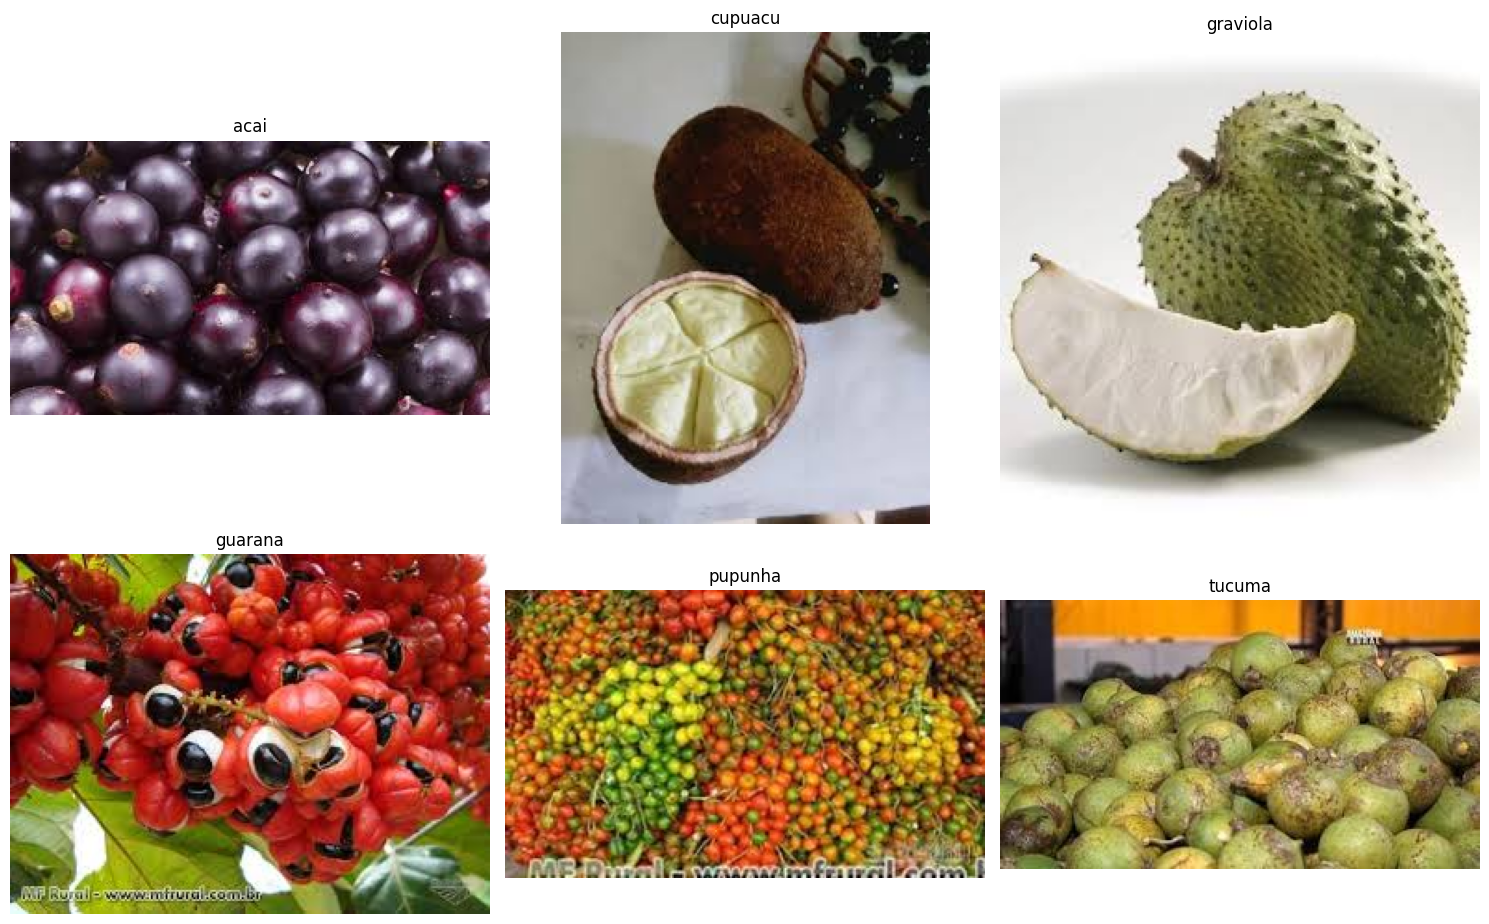

In [31]:
def visualize_samples():
    # Get only directories (ignore files like .DS_Store)
    class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    class_names = sorted(class_names)

    if len(class_names) < 6:
        print(f"Warning: Found only {len(class_names)} classes, expected 6.")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, class_name in enumerate(class_names[:6]):  # Limit to 6 classes for 2x3 grid
        class_path = os.path.join(train_dir, class_name)
        image_files = os.listdir(class_path)
        if not image_files:
            print(f"No images found in {class_path}")
            continue

        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)

        try:
            img = Image.open(image_path)
            axes[idx].imshow(img)
            axes[idx].set_title(class_name)
            axes[idx].axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    plt.tight_layout()
    plt.show()

print("Task 1: Visualizing samples")
visualize_samples()

In [33]:
def check_corrupted_images():
    corrupted_images = []
    # Get only directories (ignore files like .DS_Store)
    class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                img = Image.open(image_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

    if not corrupted_images:
        print("No corrupted images found.")

print("\nTask 1: Checking for corrupted images")
check_corrupted_images()


Task 1: Checking for corrupted images
No corrupted images found.


# TASK02: LOADING AND PREPROCESSING IMAGE DATA IN KERAS

In [43]:
# Create preprocessing layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load training dataset
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Load validation dataset
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Load test dataset
test_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Get class names from the raw training dataset (before mapping)
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Apply normalization after getting class names
train_ds = train_ds_raw.map(lambda x, y: (rescale(x), y))
val_ds = val_ds_raw.map(lambda x, y: (rescale(x), y))
test_ds = test_ds_raw.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.


# TASK03: IMPLEMENT A CNN MODEL

In [50]:
def create_model():
    model = models.Sequential([
        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu',
                     input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# TASK04: COMPILE THE MODEL

In [51]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# TRAIN THE MODEL

In [52]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1693 - loss: 1.8629

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.1684 - loss: 1.8837 - val_accuracy: 0.1667 - val_loss: 1.6670
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1777 - loss: 1.8053 - val_accuracy: 0.0000e+00 - val_loss: 1.8245
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1580 - loss: 1.7929 - val_accuracy: 0.0000e+00 - val_loss: 1.8640
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1684 - loss: 1.6918 - val_accuracy: 0.0556 - val_loss: 1.8922
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4948 - loss: 1.6243 - val_accuracy: 0.1667 - val_loss: 1.7615
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6065 - loss: 1.5194 - val_accuracy: 0.1667 - val_loss: 1.5982
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6580 - loss: 1.4044 - val_accuracy: 0.1667 - val_loss: 1.5911
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6921 - loss: 1.2214 - val_accuracy: 0.1667 - val_loss: 1.72

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7355 - loss: 0.8213 - val_accuracy: 0.8333 - val_loss: 0.9002
Epoch 12/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9219 - loss: 0.6505

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.9091 - loss: 0.6663 - val_accuracy: 0.8889 - val_loss: 0.5412
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8079 - loss: 0.6305 - val_accuracy: 0.6667 - val_loss: 0.6695
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8316 - loss: 0.4989 - val_accuracy: 0.8333 - val_loss: 0.5930
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9531 - loss: 0.3567

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9473 - loss: 0.3549 - val_accuracy: 0.9444 - val_loss: 0.5104
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9566 - loss: 0.2905 - val_accuracy: 0.7778 - val_loss: 0.9012
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9566 - loss: 0.3093 - val_accuracy: 0.7778 - val_loss: 0.7987
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9566 - loss: 0.2261 - val_accuracy: 0.8333 - val_loss: 0.5411
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9711 - loss: 0.1856 - val_accuracy: 0.7778 - val_loss: 0.5935
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9855 - loss: 0.1390 - val_accuracy: 0.6111 - val_loss: 1.1144
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9473 - loss: 0.1664 - val_accuracy: 0.7778 - val_loss: 0.7472
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9711 - loss: 0.1060 - val_accuracy: 0.9444 - val_loss: 0


Training model


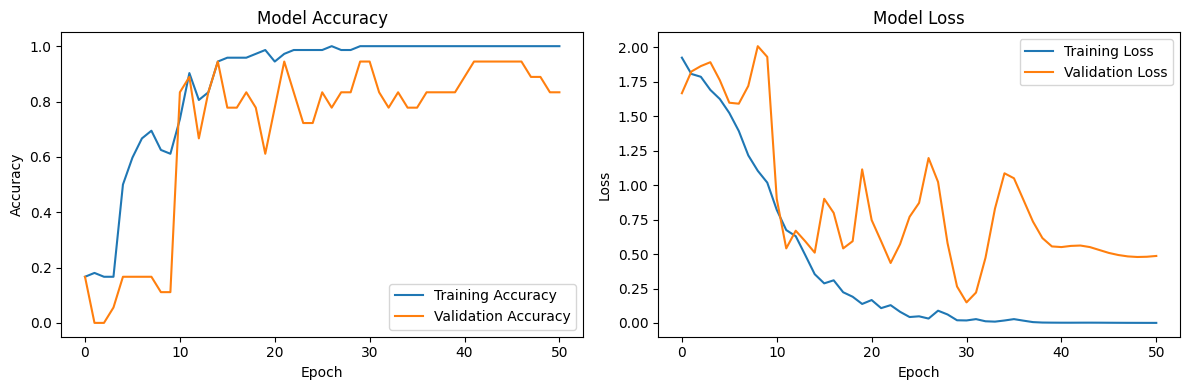

In [53]:
# Visualize training results
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nTraining model")
plot_training_history(history)

# TASK05: EVALUATE THE MODEL

In [54]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8333 - loss: 0.5876
Test accuracy: 0.8333
Test loss: 0.5876


# TASK06: SAVE AND LOAD THE MODEL

In [55]:
model.save('fruit_classifier.h5')

# Load and re-evaluate
load_model = tf.keras.models.load_model('fruit_classifier.h5')
load_test_loss, load_test_accuracy = load_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {load_test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - accuracy: 0.8333 - loss: 0.5876
Loaded model test accuracy: 0.8333


# TASK07: PREDICTIONS AND CLASSIFICATION REPORT

In [56]:
test_images = []
test_labels = []
for images, labels in test_ds.unbatch():
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = load_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step

Classification Report:
              precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.80      0.80      0.80         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      0.60      0.75         5
     pupunha       0.71      1.00      0.83         5
      tucuma       0.80      0.80      0.80         5

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30

